In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json

% matplotlib inline

In [2]:
folder = "../final_data"
figures_folder = "figures/draft"

In [3]:
figsize = (8,4)

In [33]:
baseline_cm = 10*np.log(8) / 120

### Parse info.txt files

In [98]:
def parse_all_info(folder):
    # read in all info.txt files to get metadata
    data = {}
    for root, dirs, files in os.walk(folder, topdown=True):
        for name in files:
            if "info.txt" in name:
                with open(os.path.join(root,name)) as file:
                    data[name] = json.load(file)
                    
    # parse to pandas dataframe for further use
    all_runs = pd.DataFrame.from_dict(data, orient='index')
    # create prefix column to easily access run information
    prefixes = [item[:-9] for item in list(all_runs.index)]
    all_runs["prefix"] = prefixes
    
    return all_runs

In [99]:
# read in all info.txt files to get metadata
data = {}
for root, dirs, files in os.walk(folder, topdown=True):
    for name in files:
        if "info.txt" in name:
            with open(os.path.join(root,name)) as file:
                data[name] = json.load(file)

In [100]:
# parse to pandas dataframe for further use
all_runs = pd.DataFrame.from_dict(data, orient='index')
# create prefix column to easily access run information
prefixes = [item[:-9] for item in list(all_runs.index)]
all_runs["prefix"] = prefixes

### Parse *.csv files

In [101]:
def parse_problem(problem="ap", metric="total_loss", folder="../final_data"):
    return_dict = {}
    for root, dirs, files in os.walk(folder, topdown=True):
        for name in files:
            # extract just run prefix
            if "_" in metric:
                run_key = name[4:name[:name.rfind("_")].rfind("_")]
            else:
                run_key = name[4:name.rfind("_")]
            
            # extract just problem
            prob = run_key[:run_key.find("_")]
            
            if (problem == prob) and (".csv" in name) and (metric in name):
                # if run_key is not already in return_dict, add
                if run_key not in return_dict.keys():
                    return_dict[run_key] = {}

                # parse as appropriate
                if "train" in name:
                    return_dict[run_key]["train"] = pd.read_csv(os.path.join(root,name))
                if "eval" in name:
                    return_dict[run_key]["eval"] = pd.read_csv(os.path.join(root,name))
                if "test" in name:
                    return_dict[run_key]["test"] = pd.read_csv(os.path.join(root,name))
                    
    return return_dict

In [175]:
ap = parse_problem("ap")

In [176]:
permnist_acc = parse_problem("permnist", metric="accuracy")
permnist_loss = parse_problem("permnist")

In [177]:
mnist_acc = parse_problem("mnist", metric="accuracy")
mnist_loss = parse_problem("mnist")

In [178]:
cm = parse_problem("cm")

In [179]:
results = {"ap":ap, "cm":cm, 
           "permnist_acc":permnist_acc, "permnist_loss": permnist_loss,
           "mnist_acc": mnist_acc, "mnist_loss": mnist_loss}

### Accuracy by Architecture

In [180]:
ylim = {"ap":[0,0.3], "cm":[0,0.6], "mnist_loss": [0,3], "permnist_loss":[0,3], "mnist_acc":[0,1], "permnist_acc":[0,1]}
xlim = {"ap":[0,8000], "mnist": [0,8800], "permnist": [0,8800], "cm":[0,1906]}
ylabel = {"ap": "Total Loss", "cm": "Total Loss", 
          "permnist_loss": "Total Loss", "permnist_acc": "Accuracy",
          "mnist_loss": "Total Loss", "mnist_acc": "Accuracy"}
titles = {"ap":"Adding Problem", "cm": "Copy Memory Problem", "mnist": "MNIST", "permnist": "Permuted MNIST"}

In [181]:
def plot_architecture_comparison(problem_key, data_type="train", window = 10, baseline = 0, batch_size = 32, epochs = 5):
    if "_" in problem_key:
        problem = problem_key[:problem_key.find("_")]
    else: 
        problem = problem_key
    # get prefixes (indices to get data) and net names
    prefixes = list(all_runs[all_runs.problem == problem][all_runs.optimizer == "Adam"][all_runs.epochs == epochs][all_runs.batch_size == batch_size].prefix)
    net_type = list(all_runs[all_runs.problem == problem][all_runs.optimizer == "Adam"][all_runs.epochs == epochs][all_runs.batch_size == batch_size].net_type)
    
    # try and plot each one as available
    fig = plt.figure(figsize=figsize)

    for i in range(len(prefixes)):
        # wrap plotting in try catch just incase
        try:
            plt.plot(pd.rolling_mean(results[problem_key][prefixes[i]][data_type].Step, window, center=True), 
                         pd.rolling_mean(results[problem_key][prefixes[i]][data_type].Value, window, center=True),
                         label=net_type[i])
        except:
            print("Unable to plot {}".format(prefixes[i]))
            pass
        
    if baseline > 0:
        b_length = np.linspace(*xlim[problem])
        plt.plot(b_length, [baseline]*50, ":", color="black", label="baseline")

    plt.title("Hidden Layer Comparison: {} {} ({})".format(titles[problem], 
                                                           ylabel[problem_key],
                                                           data_type))

    plt.ylim(ylim[problem_key])
    plt.xlim(xlim[problem])

    plt.ylabel(ylabel[problem_key])
    plt.xlabel("Steps")

#     plt.legend(ncol=5, loc=1)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
#     plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#            ncol=5, mode="expand", borderaxespad=0.)

    plt.tight_layout()
#     plt.show()
    
    return fig

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()


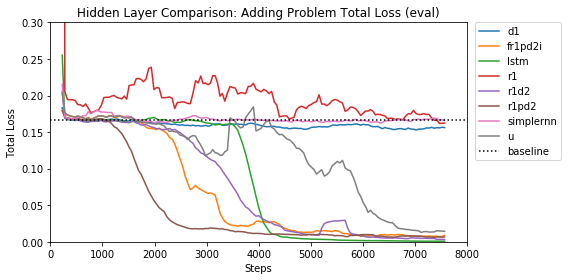

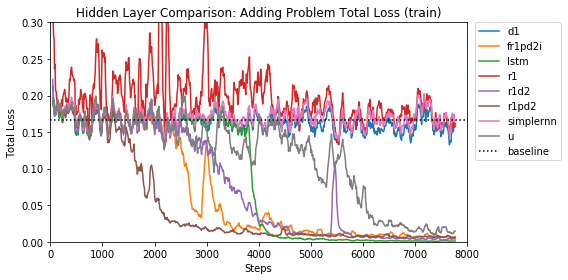

In [182]:
for trial in ["eval","train"]:
    problem_type = "ap"
    output_fig = plot_architecture_comparison(problem_type, trial, baseline=0.167, window = 10)
    output_fig.savefig(os.path.join(figures_folder, 
                                    "arch/{}_arch_comparison_{}.png".format(problem_type, trial)), dpi=300)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()


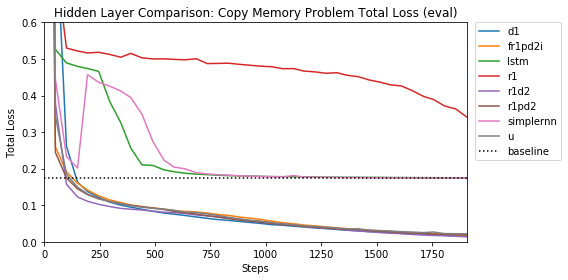

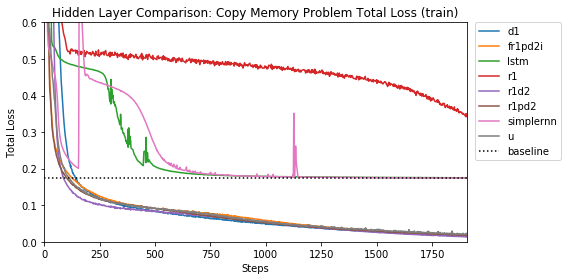

In [183]:
for trial in ["eval","train"]:
    problem_type = "cm"
    output_fig = plot_architecture_comparison(problem_type, trial, baseline=baseline_cm, 
                                              epochs=10, batch_size = 512, window=1)
    output_fig.savefig(os.path.join(figures_folder, 
                                    "arch/{}_arch_comparison_{}.png".format(problem_type, trial)), dpi=300)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()


Unable to plot mnist_fr1pd2i_08_19_1
Unable to plot mnist_fr1pd2i_08_19_1


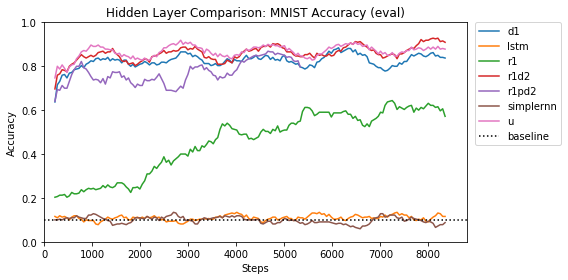

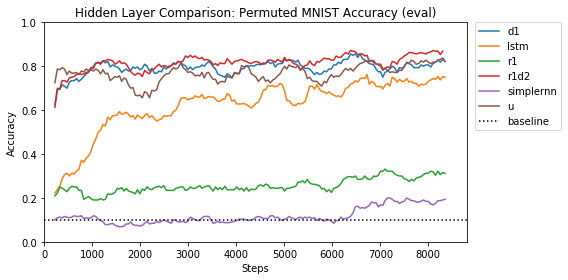

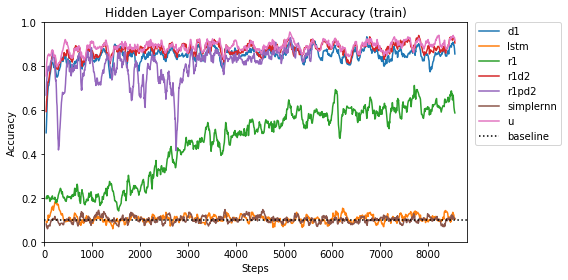

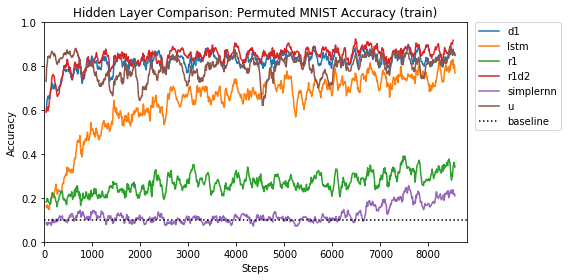

In [184]:
for trial in ["eval","train"]:
    for problem_type in ["mnist_acc", "permnist_acc"]:
        output_fig = plot_architecture_comparison(problem_type, trial, baseline=0.1)
        output_fig.savefig(os.path.join(figures_folder, 
                                        "arch/{}_arch_comparison_{}.png".format(problem_type, trial)), dpi=300)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()


Unable to plot mnist_fr1pd2i_08_19_1
Unable to plot mnist_fr1pd2i_08_19_1


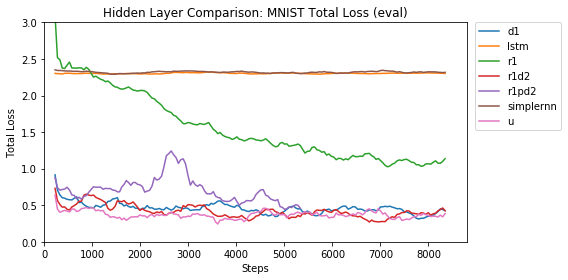

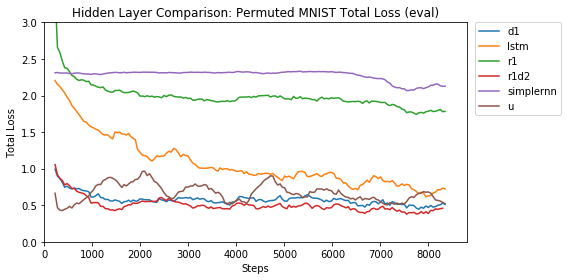

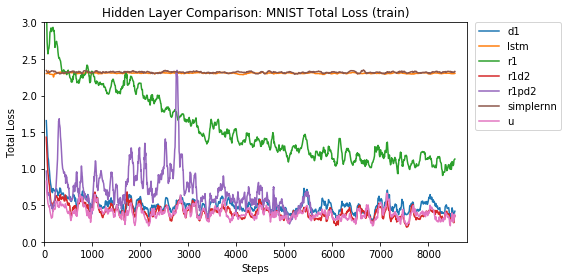

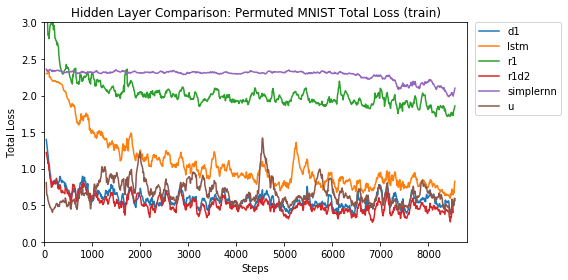

In [185]:
for trial in ["eval","train"]:
    for problem_type in ["mnist_loss", "permnist_loss"]:
        output_fig = plot_architecture_comparison(problem_type, trial)
        output_fig.savefig(os.path.join(figures_folder, 
                                        "arch/{}_arch_comparison_{}.png".format(problem_type, trial)), dpi=300)

### Accuracy by Training Method

In [438]:
def plot_training_comparison(problem_key, data_type="train", window = 10, 
                             baseline = 0, epochs=5, batch_size=32, plot_by="step"):
    if "_" in problem_key:
        problem = problem_key[:problem_key.find("_")]
    else: 
        problem = problem_key
    # get prefixes (indices to get data) and net names
    prefixes = list(all_runs[all_runs.problem == problem][all_runs.net_type == "u"][all_runs.epochs == epochs][all_runs.batch_size == batch_size].prefix)
    net_type = list(all_runs[all_runs.problem == problem][all_runs.net_type == "u"][all_runs.epochs == epochs][all_runs.batch_size == batch_size].optimizer)
    
    # try and plot each one as available
    fig = plt.figure(figsize=figsize)
    
    xlim_int = xlim[problem]

    for i in range(len(prefixes)):
        # wrap plotting in try catch just incase
        try:
            if plot_by == "step":
                plt.plot(pd.rolling_mean(results[problem_key][prefixes[i]][data_type].Step, window, center=True), 
                         pd.rolling_mean(results[problem_key][prefixes[i]][data_type].Value, window, center=True),
                         label=net_type[i])
            elif plot_by == "time":
                time_series = pd.rolling_mean(results[problem_key][prefixes[i]][data_type]["Wall time"], window, center=True)
                time_series = time_series - time_series[0]
                plt.plot(time_series, 
                         pd.rolling_mean(results[problem_key][prefixes[i]][data_type].Value, window, center=True),
                         label=net_type[i])
                xlim_int = [0,max(time_series)]
        except:
            print("Unable to plot {}".format(prefixes[i]))
            pass
        
    if baseline > 0:
        b_length = np.linspace(*xlim_int)
        plt.plot(b_length, [baseline]*len(b_length), ":", color="black", label="baseline")

    plt.title("Training Method Comparison: {} {} ({})".format(titles[problem], 
                                                           ylabel[problem_key],
                                                           data_type))

    plt.ylim(ylim[problem_key])
    try:
        plt.xlim(xlim_int)
    except:
        plt.xlim(xlim[problem])

    plt.ylabel(ylabel[problem_key])
    if plot_by == "step":
        plt.xlabel("Steps")
    else:
        plt.xlabel("Time (s)")

    plt.legend()
#     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
#     plt.show()
    
    return fig

In [439]:
ylim["ap"]= [0,1.3]

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()


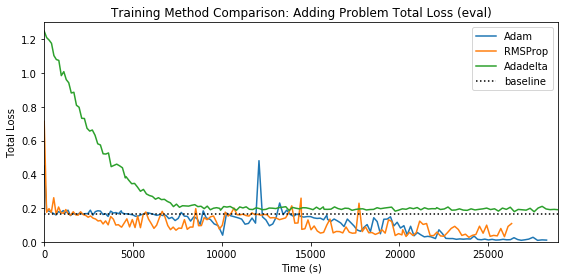

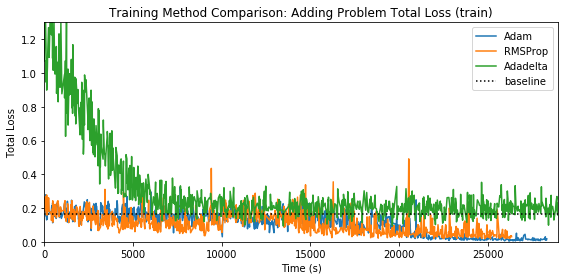

In [440]:
problem_type = "ap"
for trial in ["eval","train"]:
    output_fig = plot_training_comparison(problem_type, trial, baseline=0.167, window=1, plot_by="time")
    output_fig.savefig(os.path.join(figures_folder, "opt/{}_training_{}.png".format(problem_type, trial)), dpi=300)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()


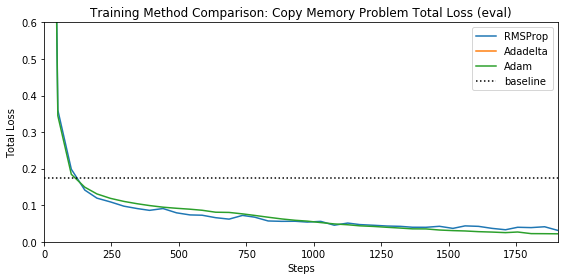

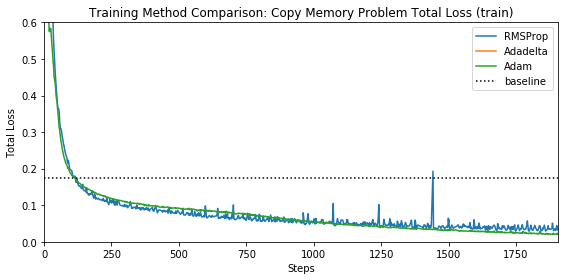

In [444]:
problem_type = "cm"
for trial in ["eval","train"]:
    output_fig = plot_training_comparison(problem_type, trial, baseline=baseline_cm, 
                                          epochs=10, batch_size=512, window=1, plot_by="step")
    output_fig.savefig(os.path.join(figures_folder, "opt/{}_training_{}.png".format(problem_type, trial)), dpi=300)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()


Unable to plot mnist_u_08_18_1


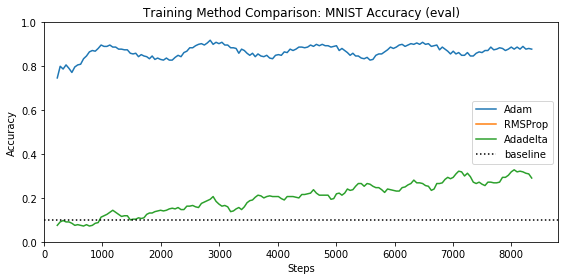

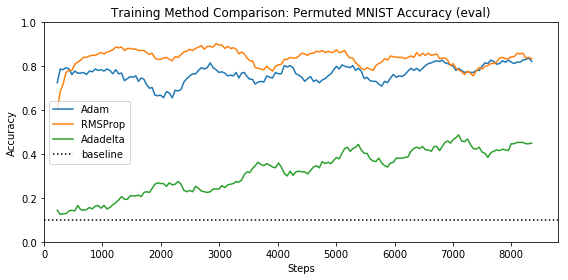

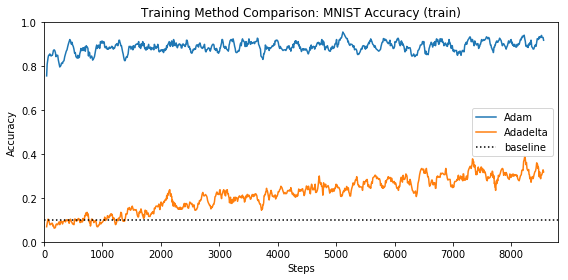

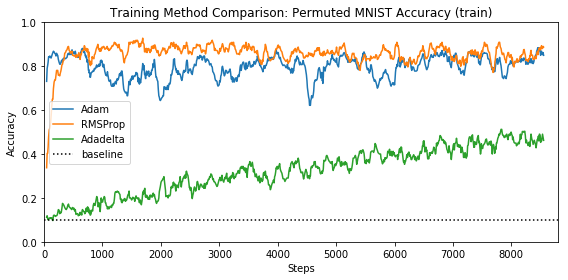

In [445]:
for trial in ["eval","train"]:
    for problem_type in ["mnist_acc", "permnist_acc"]:
        out_fig = plot_training_comparison(problem_type, trial, window=10, 
                                           baseline=0.1, plot_by="step")
        out_fig.savefig(os.path.join(figures_folder, "opt/{}_training_{}.png".format(problem_type, trial)), dpi=300)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()


Unable to plot mnist_u_08_18_1
Unable to plot mnist_u_08_18_1


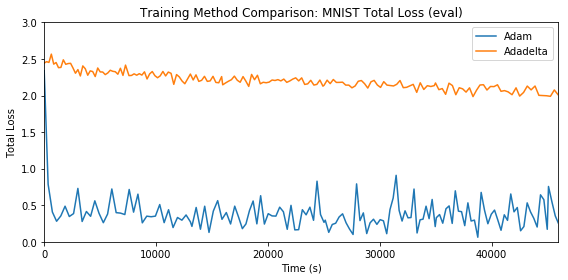

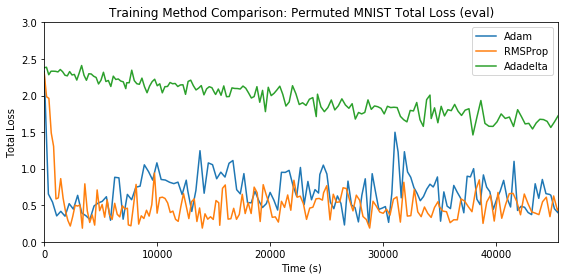

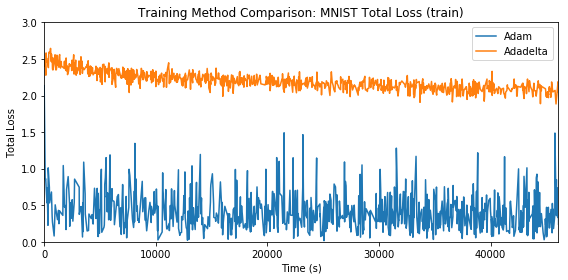

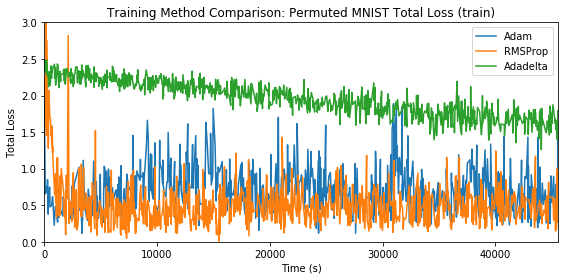

In [443]:
for trial in ["eval","train"]:
    for problem_type in ["mnist_loss", "permnist_loss"]:
        out_fig = plot_training_comparison(problem_type, trial, window=1, plot_by="time")
        out_fig.savefig(os.path.join(figures_folder, "opt/{}_training_{}.png".format(problem_type, trial)), dpi=300)

### Batch Size Exploration

In [348]:
lit_all_runs = parse_all_info("../tmp_data")

In [366]:
batch_comp = list(lit_all_runs[lit_all_runs.run_date == "08/16/19"][lit_all_runs.problem == "mnist"].prefix)
batch_size = list(lit_all_runs[lit_all_runs.run_date == "08/16/19"][lit_all_runs.problem == "mnist"].batch_size)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [363]:
batch_data_loss = parse_problem("mnist", metric="total_loss", folder="../tmp_data")
batch_data_acc = parse_problem("mnist", metric="accuracy", folder="../tmp_data")

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-pack

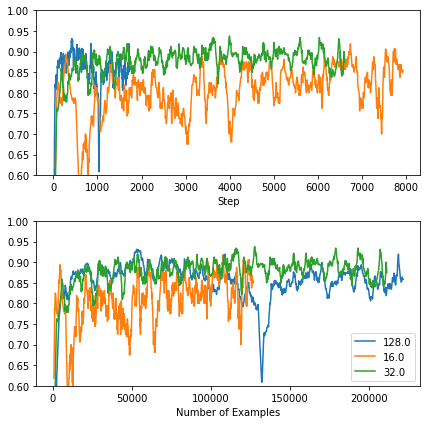

In [386]:
prefixes = batch_comp
window = 10
baseline = 0
ylim = [0.6,1]
plt.figure(figsize=(6,6))
for i in range(len(prefixes)):
    plt.subplot(211)
    plt.plot(pd.rolling_mean(batch_data_acc[prefixes[i]][data_type].Step, window, center=True), 
                 pd.rolling_mean(batch_data_acc[prefixes[i]][data_type].Value, window, center=True),
                 label=batch_size[i])
    plt.ylim(ylim)
    plt.xlabel("Step")
    
#     plt.subplot(312)
#     plt.plot(pd.rolling_mean(batch_data_acc[prefixes[i]][data_type]["Wall time"]-batch_data_acc[prefixes[i]][data_type]["Wall time"][0], window, center=True)/60, 
#                  pd.rolling_mean(batch_data_acc[prefixes[i]][data_type].Value, window, center=True),
#                  label=batch_size[i])
#     plt.ylim(ylim)
#     plt.xlabel("Wall time")
    
    plt.subplot(212)
    plt.plot(pd.rolling_mean(batch_data_acc[prefixes[i]][data_type].Step * batch_size[i], window, center=True), 
                 pd.rolling_mean(batch_data_acc[prefixes[i]][data_type].Value, window, center=True),
                 label=batch_size[i])
    plt.ylim(ylim)
    plt.xlabel("Number of Examples")
    


if baseline > 0:
    b_length = np.linspace(*xlim[problem])
    plt.plot(b_length, [baseline]*len(b_length), ":", color="black", label="baseline")

# plt.title("Batch Size Comparison: {} {} ({})".format(titles[problem], 
#                                                        ylabel[problem_key],
#                                                        data_type))


plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(figures_folder,"mnist_batch_size_comparison.png"), dpi=300)
plt.show()


In [370]:
batch_data_acc

{'mnist_u_08_16_1': {'train':         Wall time  Step     Value
  0    1.565948e+09     4  0.164062
  1    1.565948e+09     6  0.265625
  2    1.565948e+09     7  0.304688
  3    1.565948e+09     9  0.320312
  4    1.565948e+09    11  0.203125
  5    1.565948e+09    12  0.289062
  6    1.565948e+09    14  0.523438
  7    1.565948e+09    15  0.507812
  8    1.565948e+09    16  0.601562
  9    1.565948e+09    17  0.585938
  10   1.565948e+09    18  0.539062
  11   1.565948e+09    19  0.609375
  12   1.565948e+09    20  0.679688
  13   1.565948e+09    21  0.703125
  14   1.565948e+09    25  0.695312
  15   1.565948e+09    26  0.710938
  16   1.565948e+09    31  0.765625
  17   1.565948e+09    34  0.804688
  18   1.565948e+09    35  0.773438
  19   1.565948e+09    37  0.835938
  20   1.565948e+09    40  0.875000
  21   1.565948e+09    41  0.812500
  22   1.565948e+09    43  0.789062
  23   1.565948e+09    44  0.789062
  24   1.565948e+09    45  0.851562
  25   1.565948e+09    46  0.812500


In [164]:
all_runs[all_runs.problem=="cm"][all_runs.net_type == "u"][all_runs.optimizer == "RMSProp"]

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,trainable_params,name,problem,num_target,batch_size,decay,start_time,end_time,directory,gpu,...,optimizer,run_date,num_hidden,num_in,checkpoints,mnist_type,machine,samples,timesteps,prefix
cm_u_08_05_2_info.txt,2954,cm_u,cm,1,128.0,0.9,12:36:13,NaN,./logs/cm/u/08_05/2/logs,NaN,...,RMSProp,08/05/19,128,1,NaN,NaN,NaN,100000.0,120.0,cm_u_08_05_2
cm_u_08_05_3_info.txt,2954,cm_u,cm,1,128.0,0.9,20:40:26,NaN,./logs/cm/u/08_05/3//logs,NaN,...,RMSProp,08/05/19,128,1,NaN,NaN,NaN,100000.0,120.0,cm_u_08_05_3
cm_u_08_06_1_info.txt,2954,cm_u,cm,1,1024.0,0.9,11:40:32,NaN,./logs/cm/u/08_06/1/logs,NaN,...,RMSProp,08/06/19,128,1,NaN,NaN,NaN,100000.0,120.0,cm_u_08_06_1
cm_u_08_18_1_info.txt,3850,cm_u,cm,1,32.0,0.9,19:16:53,15:11:37,./logs/cm/u/08_18/1/logs,True,...,RMSProp,08/18/19,128,1,100.0,NaN,nitro.maths.ox.ac.uk,100000.0,120.0,cm_u_08_18_1
cm_u_08_20_1_info.txt,3850,cm_u,cm,1,512.0,0.9,01:15:29,03:01:57,./logs/cm/u/08_20/1/logs,True,...,RMSProp,08/20/19,128,1,100.0,NaN,nitro.maths.ox.ac.uk,100000.0,120.0,cm_u_08_20_1


In [157]:
all_runs.columns

Index(['trainable_params', 'name', 'problem', 'num_target', 'batch_size',
       'decay', 'start_time', 'end_time', 'directory', 'gpu', 'cell_type',
       'net_type', 'learning_rate', 'training_time', 'validation_frequency',
       'epochs', 'num_out', 'optimizer', 'run_date', 'num_hidden', 'num_in',
       'checkpoints', 'mnist_type', 'machine', 'samples', 'timesteps',
       'prefix'],
      dtype='object')

### Quality Evaluation

In [337]:
def quality_evaluation(problem_key, data_type="train", window = 5, batch_size = 32, epochs = 5):
    if "_" in problem_key:
        problem = problem_key[:problem_key.find("_")]
    else: 
        problem = problem_key
    # get prefixes (indices to get data) and net names
    prefixes = list(all_runs[all_runs.problem == problem][all_runs.optimizer == "Adam"][all_runs.epochs == epochs][all_runs.batch_size == batch_size].prefix)
    net_type = list(all_runs[all_runs.problem == problem][all_runs.optimizer == "Adam"][all_runs.epochs == epochs][all_runs.batch_size == batch_size].net_type)
    
    quality_evals = {}
    for prefix in prefixes:
#         model = prefix[prefix.find("_")+1:prefix.find("_")+1+prefix[prefix.find("_")+1:].find("_")]
        try:
            if "mnist" in problem_key:
                quality_evals[prefix] = pd.rolling_mean(results[problem_key][prefix][data_type].Value, 
                                                        window, center=True).max()
            else:
                quality_evals[prefix] = pd.rolling_mean(results[problem_key][prefix][data_type].Value, 
                                                        window, center=True).min()
        except:
            quality_evals[prefix] = "n/a"
            print("Can't get value for {}".format(prefix))
            
            pass
        
    return quality_evals

def model_from_prefix(prefix):
    model = prefix[prefix.find("_")+1:prefix.find("_")+1+prefix[prefix.find("_")+1:].find("_")]
    return model

In [358]:
# create table for mnist/permnist
acc = {}
for problem_key in ["permnist_acc", "mnist_acc"]:
    acc[problem_key] = {"eval": quality_evaluation(problem_key, "eval"),
                        "train": quality_evaluation(problem_key, "train")}

Can't get value for mnist_fr1pd2i_08_19_1
Can't get value for mnist_fr1pd2i_08_19_1


/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=5).mean()


In [365]:
# format into correct table format
order = ["u","fr1pd2i","r1pd2","r1d2","r1","d1","lstm","simplernn"]
mkeys = list(acc["mnist_acc"]["train"].keys())
pkeys = list(acc["permnist_acc"]["train"].keys())
print(pkeys)
for model in order:

#     print(model)

    mkey = [k for k in mkeys if "_{}_".format(model) in k][0]
    
    cells = int(all_runs[all_runs.prefix == mkey].num_hidden)
    params = int(all_runs[all_runs.prefix == mkey].trainable_params)

    try:
        pkey = [k for k in pkeys if "_{}_".format(model) in k][0]
#         print(pkey)
#         print(acc["permnist_acc"]["train"][pkey])
        pt = "{:0.4f}".format(acc["permnist_acc"]["train"][pkey])
        pe = "{:0.4f}".format(acc["permnist_acc"]["eval"][pkey])
    except:
#         print("failed on {}".format(model))
        pt = pe = "n/a"

    print("\\texttt{{{0}}} & {1} & {2} && {3} & {4} && {5} & {6} \\\ ".format(model,
                                                cells,
                                                params,
                                                acc["mnist_acc"]["train"][mkey],
                                                acc["mnist_acc"]["eval"][mkey],
                                                 pt, pe))


['permnist_r1d2_08_20_1', 'permnist_simplernn_08_17_1', 'permnist_lstm_08_17_1', 'permnist_d1_08_19_1', 'permnist_r1_08_19_1', 'permnist_u_08_17_1']
\texttt{u} & 512 & 15370 && 0.96875 & 0.925 && 0.9062 & 0.8500 \\ 
\texttt{fr1pd2i} & 512 & 13322 && n/a & n/a && n/a & n/a \\ 
\texttt{r1pd2} & 512 & 13322 && 0.94375 & 0.88125 && n/a & n/a \\ 
\texttt{r1d2} & 512 & 13322 && 0.975 & 0.94375 && 0.9437 & 0.8875 \\ 
\texttt{r1} & 512 & 12810 && 0.7625 & 0.65625 && 0.4562 & 0.3438 \\ 
\texttt{d1} & 512 & 12298 && 0.95 & 0.89375 && 0.9375 & 0.8750 \\ 
\texttt{lstm} & 128 & 67850 && 0.19375 & 0.15 && 0.8562 & 0.7937 \\ 
\texttt{simplernn} & 128 & 17930 && 0.16875 & 0.15 && 0.2812 & 0.2250 \\ 


In [355]:
acc["permnist_acc"]["train"]['permnist_r1d2_08_20_1']

0.94375

In [377]:
# create table for adding problem
acc = {}
ap_acc_df = pd.DataFrame(columns = ["model","cells","params","train","eval"])
problem_key = "ap"
acc = {"eval": quality_evaluation(problem_key, "eval"),
           "train": quality_evaluation(problem_key, "train")}
# format into correct table format
order = ["u","fr1pd2i","r1pd2","r1d2","r1","d1","lstm","simplernn"]
keys = list(acc["train"].keys())
for model in order:

#     try:
    key = [k for k in keys if "_{}_".format(model) in k][0]

    cells = int(all_runs[all_runs.prefix == key].num_hidden)
    params = int(all_runs[all_runs.prefix == key].trainable_params)

    pt = acc["train"][key]
    pe = acc["eval"][key]
#     except:
#         pt = pe = "n/a"

    print("\\texttt{{{0}}} & {1} & {2} && {3:0.4f} & {4:0.4f}  \\\ ".format(model,
                                                cells,
                                                params,
                                                 pt, pe))
    
    ap_acc_df.append({"model":model,"cells":cells,"params":params,"train":pt,"eval":pe}, ignore_index=True)


\texttt{u} & 512 & 7169 && 0.0088 & 0.0121  \\ 
\texttt{fr1pd2i} & 512 & 5121 && 0.0039 & 0.0059  \\ 
\texttt{r1pd2} & 512 & 5121 && 0.0041 & 0.0055  \\ 
\texttt{r1d2} & 512 & 5121 && 0.0021 & 0.0027  \\ 
\texttt{r1} & 512 & 4609 && 0.1202 & 0.1591  \\ 
\texttt{d1} & 512 & 4097 && 0.1162 & 0.1502  \\ 
\texttt{lstm} & 128 & 67201 && 0.0004 & 0.0007  \\ 
\texttt{simplernn} & 128 & 16897 && 0.1221 & 0.1607  \\ 


/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=5).mean()


In [375]:
# ap_acc_df = pd.DataFrame(columns = ["model","cells","params","train","eval"])
ap_acc_df

""


In [341]:
# create table for adding problem
acc = {}
window = 1
problem_key = "cm"
acc = {"eval": quality_evaluation(problem_key, "eval", epochs=10, batch_size=512, window=window),
       "train": quality_evaluation(problem_key, "train", epochs=10, batch_size=512, window=window)}

# format into correct table format
order = ["u","fr1pd2i","r1pd2","r1d2","r1","d1","lstm","simplernn"]
keys = list(acc["train"].keys())
for model in order:

#     try:
    key = [k for k in keys if "_{}_".format(model) in k][0]

    cells = int(all_runs[all_runs.prefix == key].num_hidden)
    params = int(all_runs[all_runs.prefix == key].trainable_params)

    pt = acc["train"][key]
    pe = acc["eval"][key]
#     except:
#         pt = pe = "n/a"

    print("\\texttt{{{0}}} & {1} & {2} && {3:0.4f} & {4:0.4f}  \\\ ".format(model,
                                                cells,
                                                params,
                                                 pt, pe))


\texttt{u} & 128 & 3850 && 0.0191 & 0.0218  \\ 
\texttt{fr1pd2i} & 128 & 3338 && 0.0168 & 0.0179  \\ 
\texttt{r1pd2} & 128 & 3338 && 0.0170 & 0.0182  \\ 
\texttt{r1d2} & 128 & 3338 && 0.0126 & 0.0136  \\ 
\texttt{r1} & 128 & 3210 && 0.3291 & 0.3411  \\ 
\texttt{d1} & 128 & 3082 && 0.0144 & 0.0155  \\ 
\texttt{lstm} & 40 & 7130 && 0.1749 & 0.1751  \\ 
\texttt{simplernn} & 80 & 7370 && 0.1743 & 0.1744  \\ 


/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=1).mean()


# SCRATCH

In [159]:
# get prefixes (indices to get data) and net names
prefixes = list(all_runs[all_runs.problem == problem][all_runs.optimizer == "Adam"][all_runs.epochs == 5].prefix)
net_type = list(all_runs[all_runs.problem == problem][all_runs.optimizer == "Adam"][all_runs.epochs == 5].net_type)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()


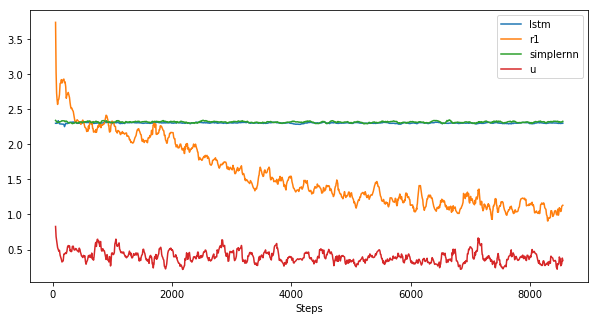

In [160]:
# try and plot each one as available
plt.figure(figsize=(10,5))

window = 10
data_type = "train"

for i in range(len(prefixes)):
    # wrap plotting in try catch just incase
    try:
        plt.plot(pd.rolling_mean(results[problem_key][prefixes[i]][data_type].Step, window, center=True), 
                 pd.rolling_mean(results[problem_key][prefixes[i]][data_type].Value, window, center=True),
                 label=net_type[i])
    except:
        pass


# plt.ylim(ylim[problem_key])
# plt.xlim(xlim[problem])

# plt.ylabel(ylabel[problem])
plt.xlabel("Steps")

plt.legend()
    
plt.show()

In [148]:
results["mnist_loss"]

{'mnist_lstm_08_17_1': {'eval':         Wall time  Step     Value
  0    1.566043e+09     1  2.303051
  1    1.566043e+09    51  2.306343
  2    1.566044e+09   101  2.307438
  3    1.566044e+09   151  2.232208
  4    1.566044e+09   201  2.304838
  5    1.566044e+09   251  2.294531
  6    1.566044e+09   301  2.334783
  7    1.566045e+09   351  2.318333
  8    1.566045e+09   401  2.302000
  9    1.566045e+09   451  2.322717
  10   1.566045e+09   501  2.280175
  11   1.566045e+09   551  2.288981
  12   1.566045e+09   601  2.272181
  13   1.566045e+09   651  2.317689
  14   1.566045e+09   701  2.306597
  15   1.566045e+09   751  2.309278
  16   1.566045e+09   801  2.294016
  17   1.566046e+09   851  2.302644
  18   1.566046e+09   901  2.302733
  19   1.566046e+09   951  2.315261
  20   1.566046e+09  1001  2.295971
  21   1.566046e+09  1051  2.321892
  22   1.566046e+09  1101  2.279328
  23   1.566046e+09  1151  2.307753
  24   1.566046e+09  1201  2.293426
  25   1.566046e+09  1251  2.30799

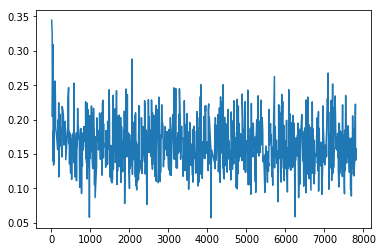

In [113]:
plt.plot(results["ap"][prefixes[0]]["train"].Step, results["ap"][prefixes[0]]["train"].Value)

In [272]:
all_runs[all_runs.problem == "mnist"]

,num_hidden,num_out,gpu,training_time,start_time,directory,epochs,net_type,batch_size,num_in,...,optimizer,trainable_params,run_date,num_target,checkpoints,timesteps,machine,samples,mnist_type,prefix
mnist_d1_08_19_1_info.txt,512,10,True,NaN,09:21:46,./logs/mnist/d1/08_19/1/logs,5,d1,32,1,...,Adam,12298,08/19/19,1,100.0,NaN,forge.maths.ox.ac.uk,NaN,mnist,mnist_d1_08_19_1
mnist_lstm_08_17_1_info.txt,128,10,True,20660.612815,13:02:59,./logs/mnist/lstm/08_17/1/logs,5,lstm,32,1,...,Adam,67850,08/17/19,1,NaN,NaN,NaN,NaN,NaN,mnist_lstm_08_17_1
mnist_r1_08_19_1_info.txt,512,10,True,20084.615720,03:46:40,./logs/mnist/r1/08_19/1/logs,5,r1,32,1,...,Adam,12810,08/19/19,1,100.0,NaN,forge.maths.ox.ac.uk,NaN,mnist,mnist_r1_08_19_1
mnist_simplernn_08_17_1_info.txt,128,10,True,15728.009376,18:47:43,./logs/mnist/simplernn/08_17/1/logs,5,simplernn,32,1,...,Adam,17930,08/17/19,1,NaN,NaN,NaN,NaN,NaN,mnist_simplernn_08_17_1
mnist_u_08_17_1_info.txt,512,10,True,56728.508051,23:10:10,./logs/mnist/u/08_17/1/logs,5,u,32,1,...,Adam,15370,08/17/19,1,100.0,NaN,forge.maths.ox.ac.uk,NaN,mnist,mnist_u_08_17_1
mnist_u_08_18_1_info.txt,512,10,True,NaN,14:56:07,./logs/mnist/u/08_18/1/logs,5,u,32,1,...,RMSProp,15370,08/18/19,1,100.0,NaN,forge.maths.ox.ac.uk,NaN,mnist,mnist_u_08_18_1
mnist_u_08_18_2_info.txt,512,10,True,46167.486050,14:56:44,./logs/mnist/u/08_18/2/logs,5,u,32,1,...,Adadelta,15370,08/18/19,1,100.0,NaN,forge.maths.ox.ac.uk,NaN,mnist,mnist_u_08_18_2


In [257]:
results["permnist_"]

{'ap_d1_08_18_1_info.txt': {'batch_size': 32,
  'cell_type': 'flexi_cell',
  'checkpoints': 100,
  'decay': 0.9,
  'directory': './logs/ap/d1/08_18/1/logs',
  'end_time': '22:43:51',
  'epochs': 5,
  'gpu': True,
  'learning_rate': 0.001,
  'machine': 'nitro.maths.ox.ac.uk',
  'name': 'ap_d1',
  'net_type': 'd1',
  'num_hidden': 512,
  'num_in': 2,
  'num_out': 1,
  'num_target': 1,
  'optimizer': 'Adam',
  'problem': 'ap',
  'run_date': '08/18/19',
  'samples': 50000,
  'start_time': '19:18:28',
  'timesteps': 100,
  'trainable_params': 4097,
  'training_time': 12313.787383,
  'validation_frequency': 50},
 'ap_fr1pd2i_08_19_1_info.txt': {'batch_size': 32,
  'cell_type': 'flexi_cell',
  'checkpoints': 100,
  'decay': 0.9,
  'directory': './logs/ap/fr1pd2i/08_19/1/logs',
  'end_time': '08:16:44',
  'epochs': 5,
  'gpu': True,
  'learning_rate': 0.001,
  'machine': 'nitro.maths.ox.ac.uk',
  'name': 'ap_fr1pd2i',
  'net_type': 'fr1pd2i',
  'num_hidden': 512,
  'num_in': 2,
  'num_out': 1,

In [97]:
all_runs[all_runs.problem == "permnist"]

,trainable_params,name,problem,num_target,batch_size,decay,start_time,end_time,directory,gpu,...,optimizer,run_date,num_hidden,num_in,checkpoints,mnist_type,machine,samples,timesteps,prefix
permnist_d1_08_19_1_info.txt,12298,permnist_d1,permnist,1,32.0,0.9,21:53:01,02:39:20,./logs/permnist/d1/08_19/1/logs,True,...,Adam,08/19/19,512,1,100.0,permnist,forge.maths.ox.ac.uk,NaN,NaN,permnist_d1_08_19_1
permnist_lstm_08_17_1_info.txt,67850,permnist_lstm,permnist,1,32.0,0.9,13:14:53,18:59:31,./logs/permnist/lstm/08_17/1/logs,True,...,Adam,08/17/19,128,1,NaN,NaN,NaN,NaN,NaN,permnist_lstm_08_17_1
permnist_r1_08_19_1_info.txt,12810,permnist_r1,permnist,1,32.0,0.9,16:30:40,21:52:40,./logs/permnist/r1/08_19/1/logs,True,...,Adam,08/19/19,512,1,100.0,permnist,forge.maths.ox.ac.uk,NaN,NaN,permnist_r1_08_19_1
permnist_r1d2_08_20_1_info.txt,13322,permnist_r1d2,permnist,1,32.0,0.9,02:39:46,NaN,./logs/permnist/r1d2/08_20/1/logs,True,...,Adam,08/20/19,512,1,100.0,permnist,forge.maths.ox.ac.uk,NaN,NaN,permnist_r1d2_08_20_1
permnist_simplernn_08_17_1_info.txt,17930,permnist_simplernn,permnist,1,32.0,0.9,19:00:28,23:19:16,./logs/permnist/simplernn/08_17/1/logs,True,...,Adam,08/17/19,128,1,NaN,NaN,NaN,NaN,NaN,permnist_simplernn_08_17_1
permnist_u_08_17_1_info.txt,15370,permnist_u,permnist,1,32.0,0.9,23:19:34,14:55:58,./logs/permnist/u/08_17/1/logs,True,...,Adam,08/17/19,512,1,100.0,permnist,forge.maths.ox.ac.uk,NaN,NaN,permnist_u_08_17_1
permnist_u_08_18_1_info.txt,15370,permnist_u,permnist,1,32.0,0.9,14:56:24,03:48:00,./logs/permnist/u/08_18/1/logs,True,...,RMSProp,08/18/19,512,1,100.0,permnist,forge.maths.ox.ac.uk,NaN,NaN,permnist_u_08_18_1
permnist_u_08_19_1_info.txt,15370,permnist_u,permnist,1,32.0,0.9,03:48:25,16:30:09,./logs/permnist/u/08_19/1/logs,True,...,Adadelta,08/19/19,512,1,100.0,permnist,forge.maths.ox.ac.uk,NaN,NaN,permnist_u_08_19_1


In [167]:
results["cm"]["cm_d1_08_19_1"]["eval"].Value.min()

0.015475887805223463

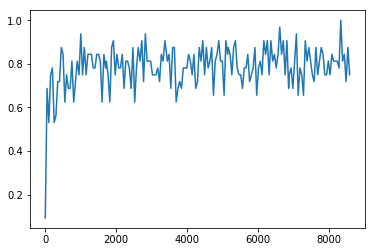

In [194]:
plt.plot(results["permnist_acc"]["permnist_d1_08_19_1"]["eval"].Step,
         results["permnist_acc"]["permnist_d1_08_19_1"]["eval"].Value)

In [198]:
window=10
pd.rolling_mean(results["permnist_acc"]["permnist_d1_08_19_1"]["eval"].Value, window, center=True).max()

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
  from ipykernel import kernelapp as app


0.85625

In [200]:
pd.rolling_mean(results["permnist_acc"]["permnist_d1_08_19_1"]["train"].Value, window, center=True).max()

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=10).mean()
  if __name__ == '__main__':


0.9

In [201]:
def quality_evaluation(problem_key, data_type="train", window = 10, baseline = 0, batch_size = 32, epochs = 5):
    if "_" in problem_key:
        problem = problem_key[:problem_key.find("_")]
    else: 
        problem = problem_key
    # get prefixes (indices to get data) and net names
    prefixes = list(all_runs[all_runs.problem == problem][all_runs.optimizer == "Adam"][all_runs.epochs == epochs][all_runs.batch_size == batch_size].prefix)
    net_type = list(all_runs[all_runs.problem == problem][all_runs.optimizer == "Adam"][all_runs.epochs == epochs][all_runs.batch_size == batch_size].net_type)
    
    quality_evals = {}
    for prefix in prefixes:
        quality_evals[prefix] = pd.rolling_mean(results[problem_key][prefix]["train"].Value, window, center=True).max()
        
    return quality_evals

In [206]:
quality_evaluation("permnist_acc", window=5)

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=True,window=5).mean()


{'permnist_d1_08_19_1': 0.9375,
 'permnist_lstm_08_17_1': 0.85625,
 'permnist_r1_08_19_1': 0.45625,
 'permnist_r1d2_08_20_1': 0.94375,
 'permnist_simplernn_08_17_1': 0.28125,
 'permnist_u_08_17_1': 0.90625}

In [382]:
all_runs[all_runs.problem == "mnist"].epochs

mnist_d1_08_10_1_info.txt            NaN
mnist_d1_08_13_1_info.txt            NaN
mnist_d1_08_19_1_info.txt            5.0
mnist_fr1pd2i_08_19_1_info.txt       5.0
mnist_lstm_08_12_1_info.txt          NaN
mnist_lstm_08_12_2_info.txt          NaN
mnist_lstm_08_12_3_info.txt          NaN
mnist_lstm_08_17_1_info.txt          5.0
mnist_r1_08_10_1_info.txt            NaN
mnist_r1_08_13_1_info.txt            NaN
mnist_r1_08_19_1_info.txt            5.0
mnist_r1d2_08_19_1_info.txt          5.0
mnist_r1pd2_08_19_1_info.txt         5.0
mnist_simplernn_08_12_1_info.txt     NaN
mnist_simplernn_08_13_1_info.txt     NaN
mnist_simplernn_08_17_1_info.txt     5.0
mnist_u_08_10_1_info.txt             NaN
mnist_u_08_10_2_info.txt             NaN
mnist_u_08_12_1_info.txt             NaN
mnist_u_08_13_1_info.txt             NaN
mnist_u_08_13_2_info.txt             NaN
mnist_u_08_14_1_info.txt            10.0
mnist_u_08_14_2_info.txt            10.0
mnist_u_08_15_1_info.txt            10.0
mnist_u_08_15_2_